<a href="https://colab.research.google.com/github/OscarCabreraRodriguez/AnomalyDetectionSwat2019/blob/main/week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports the required packages 

from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import io
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
from sklearn.mixture import GaussianMixture
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     
from sklearn import mixture
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier 
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectPercentile

In [ ]:
# mount the data from google drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_excel('/content/gdrive/My Drive/SWaT_dataset_Jul 19 v2.xlsx', parse_dates = ['GMT +0'], index_col = 'GMT +0')

# EDA


In [ ]:
df.shape

(14996, 77)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14996 entries, 2019-07-20 08:39:59.004013+00:00 to 2019-07-20 04:30:00+00:00
Data columns (total 77 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FIT 101      14996 non-null  float64
 1   LIT 101      14996 non-null  float64
 2   MV 101       14996 non-null  int64  
 3   P1_STATE     14996 non-null  int64  
 4   P101 Status  14996 non-null  int64  
 5   P102 Status  14996 non-null  int64  
 6   AIT 201      14996 non-null  float64
 7   AIT 202      14996 non-null  float64
 8   AIT 203      14996 non-null  float64
 9   FIT 201      14996 non-null  float64
 10  LS 201       14996 non-null  object 
 11  LS 202       14996 non-null  object 
 12  LSL 203      14996 non-null  object 
 13  LSLL 203     14996 non-null  object 
 14  MV201        14996 non-null  int64  
 15  P2_STATE     14996 non-null  int64  
 16  P201 Status  14996 non-null  int64  
 17  P202 Status  14996 non-null  int64

In [ ]:
def plot_time_series(df, col, title):
    plt.figure(figsize=(20, 5))
    plt.plot(df[col])
    plt.title(col)
    plt.show()

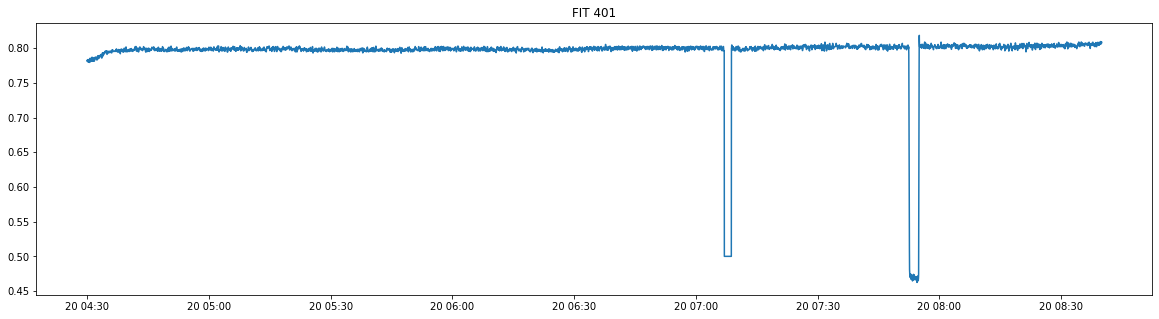

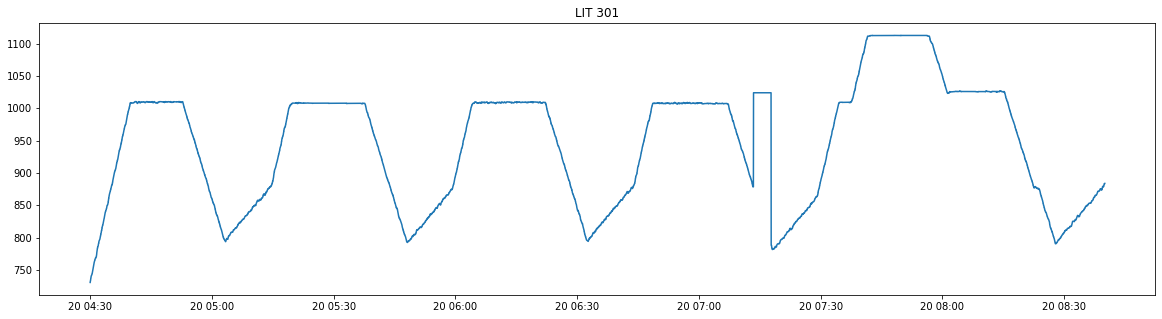

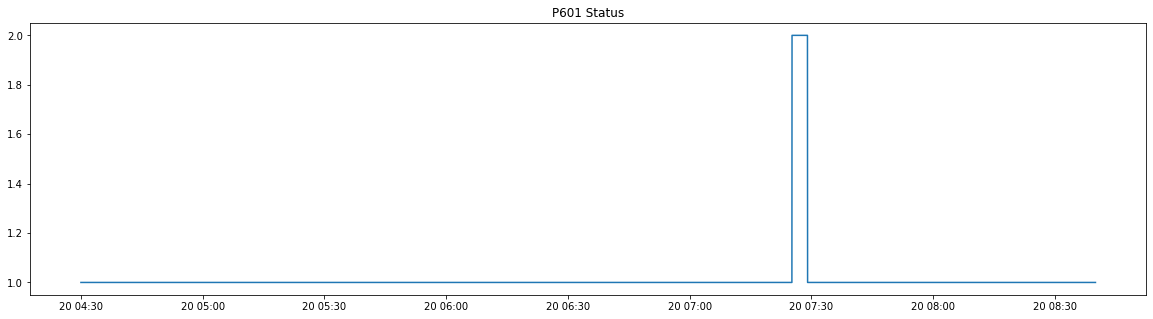

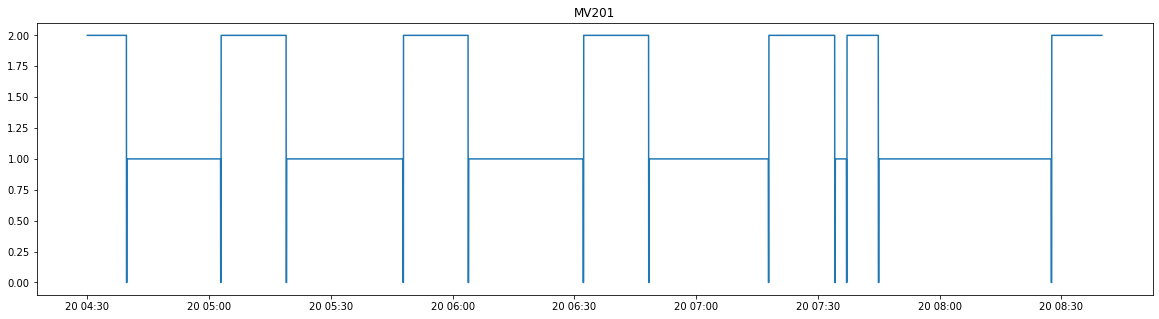

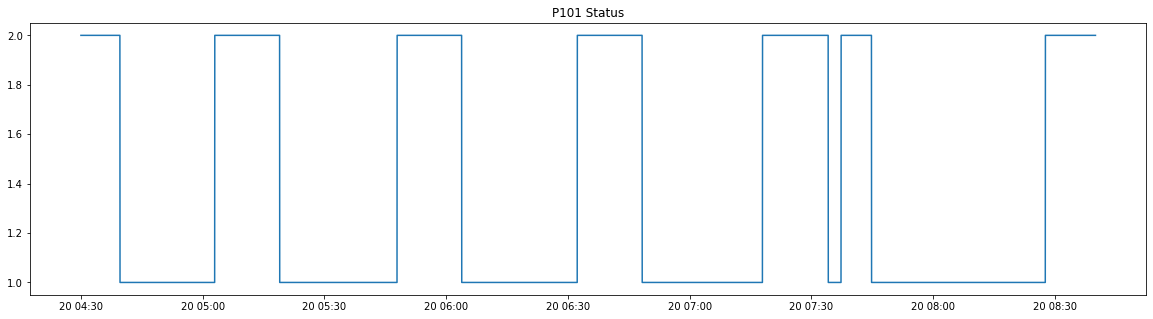

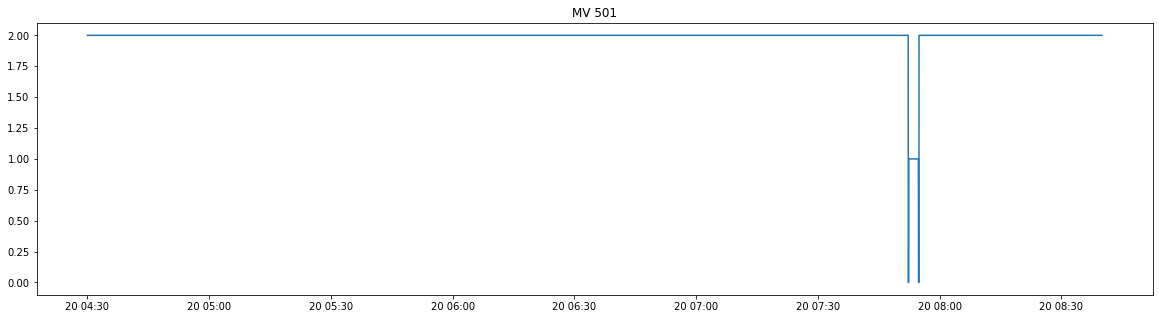

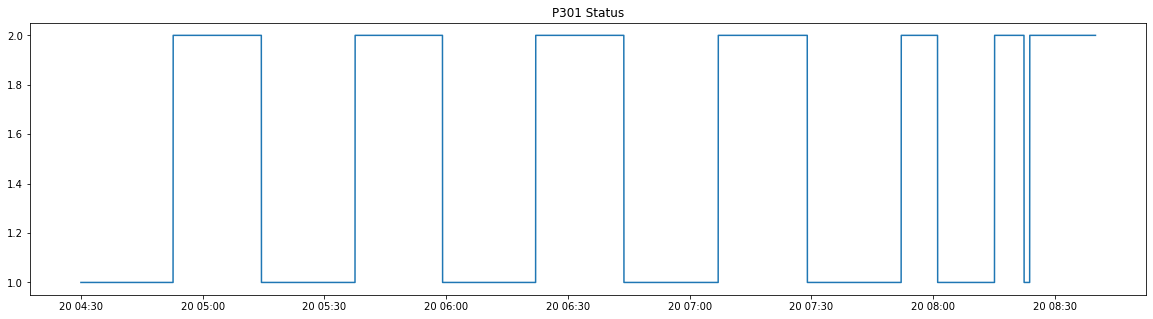

In [ ]:
cols = ['FIT 401', 'LIT 301', 'P601 Status','MV201','P101 Status','MV 501','P301 Status']
for col in cols:
    plot_time_series(df, col, 'GMT +0')

# Data Reading

In [ ]:
 #active 1 inactive 0
#  'LS 201', 'LS 202','LSL 203','LSLL 203'  ,'LS 401','LSH 601','LSH 602','LSH 603','LSL 601','LSL 602','LSL 603'
df['LS 201']=np.where(df['LS 201'] == 'Active', 1, 0)
df['LS 202']=np.where(df['LS 202'] == 'Active', 1, 0)
df['LSL 203']=np.where(df['LSL 203'] == 'Inactive', 0, 1)
df['LSLL 203']=np.where(df['LSLL 203'] == 'Active', 1, 0)
df['LS 401']=np.where(df['LS 401'] == 'Active', 1, 0)
df['LSH 601']=np.where(df['LSH 601'] == 'Active', 1, 0)
df['LSH 602']=np.where(df['LSH 602'] == 'Active', 1, 0)
df['LSH 603']=np.where(df['LSH 603'] == 'Active', 1, 0)
df['LSL 601']=np.where(df['LSL 601'] == 'Active', 1, 0)
df['LSL 602']=np.where(df['LSL 602'] == 'Active', 1, 0)
df['LSL 603']=np.where(df['LSL 603'] == 'Active', 1, 0)


In [ ]:
#Data description - classfiying the coloumns in to sessor and actuator 
 #In SWaT, the sensor data can be continuous, while pumps only have 2 statuses (2 = open and 1 = closed), 
 #active 1 inactive 0


#  'LS 201', 'LS 202','LSL 203','LSLL 203'  ,'LS 401','LSH 601','LSH 602','LSH 603','LSL 601','LSL 602','LSL 603'
 



sensor_columns = ['FIT 101','LIT 101','AIT 201','AIT 202','AIT 203','FIT 201','AIT 301','AIT 302','AIT 303','DPIT 301','FIT 301','LIT 301','AIT 402','FIT 401','LIT 401',

'AIT 501','AIT 502','AIT 503','AIT 504','FIT 501','FIT 502','FIT 503','FIT 504','PIT 501','PIT 502',	'PIT 503','FIT 601'
]
actuator_columns = ['MV 101','P1_STATE','P101 Status', 'P102 Status', 'LS 201', 'LS 202','LSL 203','LSLL 203','MV201','P2_STATE','P201 Status','P202 Status','P203 Status','P204 Status','P205 Status','P206 Status','P207 Status','P208 Status',
                    'MV 301','MV 302','MV 303','MV 304','P3_STATE','P301 Status','P302 Status','AIT 401',
'LS 401','P4_STATE','P401 Status','P402 Status','P403 Status','P404 Status','UV401','MV 501','MV 502','MV 503','MV 504','P5_STATE','P501 Status','P502 Status',
'LSH 601','LSH 602','LSH 603','LSL 601','LSL 602','LSL 603','P6 STATE','P601 Status','P602 Status','P603 Status'

]
timestamp_col = 'Timestamp' 
label_col = 'Normal/Attack'

#Data Reading
df = pd.read_excel('/content/gdrive/My Drive/SWaT_dataset_Jul 19 v2.xlsx', parse_dates = ['GMT +0'], index_col = 'GMT +0')
#df = pd.read_csv('/content/gdrive/My Drive/LAB1 PROJECT/SWaT_Dataset_Attack_v0 - Copy.csv', parse_dates = ['Timestamp'], index_col = 'Timestamp')

#Strip whitespaces
df = df.rename(columns=lambda x: x.strip())


#Data Cleanup
df = df.dropna()

# Preprocessing

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
def preprocess(df):
  df = df.copy()
 #OneHotEncode categorical data
  encoder = OneHotEncoder(sparse = False)
  enc_df = pd.DataFrame(encoder.fit_transform(df[actuator_columns]))
  enc_df.index = df.index
  df.drop(actuator_columns, axis='columns', inplace=True)
  
  # Normalize numerical data
  minmax_scale = pd.DataFrame(MinMaxScaler().fit_transform(df[sensor_columns]))
  minmax_scale.index = df.index 
  df.drop(sensor_columns, axis='columns', inplace=True)
  retVal = pd.concat([enc_df,df, minmax_scale], axis=1, ignore_index=True) 
  retVal = retVal.reindex(df.index)
  return retVal 
  
processed_df = preprocess(df)
processed_df.head(2)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109
GMT +0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-20 08:39:59.004013+00:00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.98189,0.005172,0.532556,0.755771,0.806563,0.987745,0.728497,0.391461,0.004886,0.942354,0.926161,0.400985,0.004847,0.970514,0.834892,0.991001,0.027422,0.416675,0.05082,0.947004,0.703417,0.123024,0.15264,0.011842,0.000253,0.036171,0.002333
2019-07-20 08:39:58.005004800+00:00,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.98189,0.003879,0.532556,0.759768,0.803454,0.987745,0.728497,0.391461,0.004886,0.942354,0.926161,0.400985,0.004847,0.972312,0.833334,0.991001,0.027422,0.416675,0.05082,0.950814,0.691943,0.123024,0.15264,0.011842,0.000253,0.036171,0.002333


In [ ]:
# atak 1 normal 0
processed_df.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
5      float64
6      float64
7      float64
8      float64
9      float64
10     float64
11     float64
12     float64
13     float64
14     float64
15     float64
16     float64
17     float64
18     float64
19     float64
20     float64
21     float64
22     float64
23     float64
24     float64
25     float64
26     float64
27     float64
28     float64
29     float64
30     float64
31     float64
32     float64
33     float64
34     float64
35     float64
36     float64
37     float64
38     float64
39     float64
40     float64
41     float64
42     float64
43     float64
44     float64
45     float64
46     float64
47     float64
48     float64
49     float64
50     float64
51     float64
52     float64
53     float64
54     float64
55     float64
56     float64
57     float64
58     float64
59     float64
60     float64
61     float64
62     float64
63     float64
64     float64
65     float64
66     flo

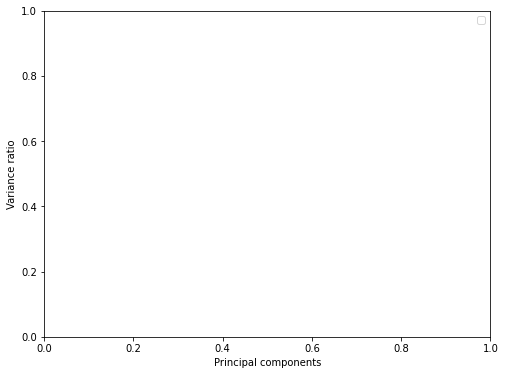

In [ ]:
# Visualize
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(processed_df)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
#plt.bar(range(22), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

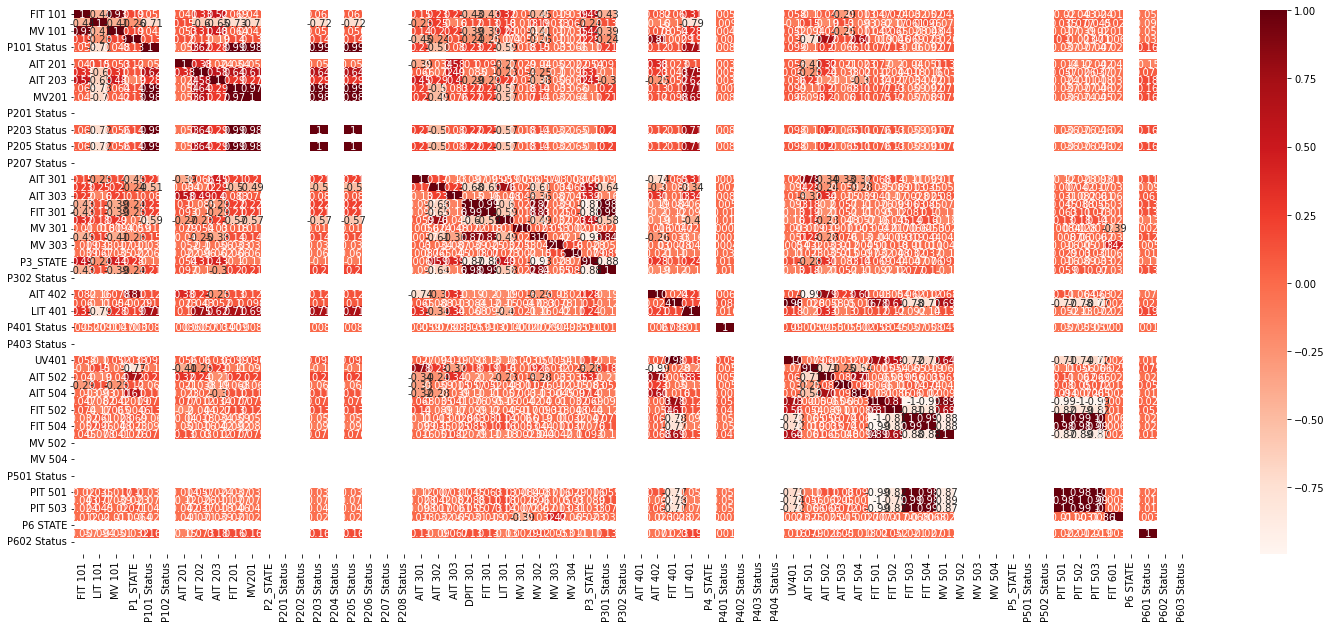

In [ ]:
#Using Pearson Correlation
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
cor = df.corr()
import seaborn as sns # data visualization library  
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


# IsolationForest


Isolation Forests
Isolation Forests is an unsupervised learning algorithm that identifies anomalies by isolating outliers in the data based on the Decision Tree Algorithm.

In [ ]:
# importing the isloation forest
from sklearn.ensemble import IsolationForest

# copying dataset
isf_dataset = processed_df.copy()

# initializing Isolation Forest
clf = IsolationForest(max_samples='auto', contamination=0.01)

# training
clf.fit(isf_dataset)

# finding anomalies
isf_dataset['Anomaly'] = clf.predict(isf_dataset)

# saving anomalies to a separate dataset for visualization purposes
anomalies = isf_dataset.query('Anomaly == -1')


In [ ]:
import plotly.graph_objects as go

b1 = go.Scatter(x=isf_dataset.index.astype(str),
                y=isf_dataset['Anomaly'],
                name="Dataset",
                mode='markers'
               )
b2 = go.Scatter(x=anomalies.index.astype(str),
                y=anomalies['Anomaly'],
                name="Anomalies",
                mode='markers',
                marker=dict(color='red', size=6,
                            line=dict(color='red', width=1))
               )

layout = go.Layout(
    title="Isolation Forest results",
    yaxis_title='Sales',
    xaxis_title='Date',
    hovermode='closest'
)

data = [b1, b2]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
anomalies

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,Anomaly
GMT +0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-20 07:54:52.004013+00:00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.987775,0.438289,0.511545,0.633851,0.000164,0.632759,0.568250,0.097720,0.969309,0.934442,0.999581,0.013329,0.034520,0.238853,0.889765,0.029806,0.583325,0.057377,0.039141,0.383637,0.935395,0.939769,0.880000,0.934717,0.823497,0.002333,-1
2019-07-20 07:54:51+00:00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.987422,0.438289,0.509325,0.633851,0.000164,0.632759,0.568852,0.097720,0.974379,0.934442,0.999581,0.013329,0.018698,0.237917,0.889765,0.027124,0.583325,0.057377,0.005542,0.077575,0.978694,0.956271,0.943421,0.983553,0.928746,0.002333,-1
2019-07-20 07:54:50.004013+00:00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.988010,0.438289,0.509325,0.633851,0.000164,0.629767,0.573061,0.097720,0.974379,0.934235,0.999581,0.013329,0.017979,0.237761,0.889765,0.027124,0.583325,0.057377,0.000000,0.000000,0.983505,0.972772,0.976579,1.000000,0.964645,0.002333,-1
2019-07-20 07:54:49.002014100+00:00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.986834,0.438289,0.509325,0.633851,0.000164,0.629767,0.573061,0.097720,0.974379,0.934166,0.999581,0.013329,0.017979,0.239164,0.889765,0.027124,0.583325,0.057377,0.000000,0.000000,0.977320,0.972772,0.976579,1.000000,0.964645,0.002333,-1
2019-07-20 07:54:48.004013+00:00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.987775,0.438289,0.507993,0.633851,0.000164,0.629767,0.573061,0.097720,0.974379,0.934166,0.999581,0.013329,0.012585,0.239164,0.889765,0.027124,0.583325,0.057377,0.000000,0.000000,0.973196,0.977723,0.977368,1.000000,0.964645,0.002333,-1
2019-07-20 07:54:47.004013+00:00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.987069,0.438289,0.504440,0.633851,0.000164,0.629767,0.577270,0.097720,0.969843,0.934166,0.999581,0.013329,0.006832,0.237293,0.889765,0.027124,0.58

In [ ]:
len(anomalies)

149

# Local Outlier Factor (LOF)

Local Outlier Factor (LOF)
The Local Outlier Factor (LOF) algorithm helps identify outliers based on the density of data points for every local data point in the dataset. The algorithm performs well when the data density is not the same throughout the dataset.


In [ ]:
# Importing then local outlier factor
from sklearn.neighbors import LocalOutlierFactor

# copying dataset
lof_dataset =processed_df.copy()

# initializing the Local Outlier Factor algorithm
clf = LocalOutlierFactor(n_neighbors=10)

# training and finding anomalies
lof_dataset['Anomaly'] = clf.fit_predict(lof_dataset)

# saving anomalies to another dataset for visualization purposes
anomalies2 = isf_dataset.query('Anomaly == -1')

In [ ]:
import plotly.graph_objects as go

b1 = go.Scatter(x=isf_dataset.index.astype(str),
                y=isf_dataset['Anomaly'],
                name="Dataset",
                mode='markers'
               )
b2 = go.Scatter(x=anomalies.index.astype(str),
                y=anomalies['Anomaly'],
                name="Anomalies",
                mode='markers',
                marker=dict(color='red', size=6,
                            line=dict(color='red', width=1))
               )

layout = go.Layout(
    title="Isolation Forest results",
    yaxis_title='Sales',
    xaxis_title='Date',
    hovermode='closest'
)

data = [b1, b2]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
len(anomalies2)

149